<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project2/blob/master/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTILS

In [0]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
#!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch


In [0]:
ROOT_DIRECTORY = '.'

In [0]:
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
ROOT_DIRECTORY = '/content/gdrive/My Drive/ELEC5307 Project2'


Mounted at /content/gdrive


# IMPORTS

In [0]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim


import numpy as np
import math
import random

import matplotlib.pyplot as plt

import os
import pickle

from torchvision.datasets import ImageFolder

import multiprocessing
from torch.optim.lr_scheduler import ReduceLROnPlateau

# HYPERPARAMETERS

In [0]:
LEARNING_RATE = 0.01
BATCH_SIZE = 32
EPOCHS = 35

log_progress_every = 3 # In iterations
evaluate_model_every = 10 # In epochs
save_model_every = 150 # In epochs
nMiniBatches = 20 #log progress

In [0]:
model_filename = '{}/saves_task2/project2.pth'.format(ROOT_DIRECTORY)
torch.save(net.state_dict(), model_filename)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Machine Parameters 


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The following study will use --- {device} --- as device')

cpu_cores = multiprocessing.cpu_count()
print(f'The following study has --- {cpu_cores} --- available cpu cores')

The following study will use --- cuda --- as device
The following study has --- 2 --- available cpu cores


# DATA LOADING & TRANSFORMATION

In [0]:
#SOURCE_FOLDER = '{}/data/Task2/Source'.format(ROOT_DIRECTORY)
#TARGET_FOLDER = '{}/data/Task2/Target'.format(ROOT_DIRECTORY)

SOURCE_NORMALIZATION = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]} # general values 
TARGET_NORMALIZATION = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

train_transform = transforms.Compose([
                                       transforms.RandomResizedCrop(227),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=SOURCE_NORMALIZATION['mean'], std=SOURCE_NORMALIZATION['std']),
])

test_transform = transforms.Compose([
                                       transforms.Resize((227, 227)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=SOURCE_NORMALIZATION['mean'], std=SOURCE_NORMALIZATION['std']),
])


TRAIN_FOLDER = '{}/data/Task1/train'.format(ROOT_DIRECTORY)
VALIDATION_FOLDER = '{}/data/Task1/val'.format(ROOT_DIRECTORY)

train_set = ImageFolder(TRAIN_FOLDER, transform=train_transform)
validation_set = ImageFolder(VALIDATION_FOLDER, transform=test_transform)


train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=16
    )

validation_loader = torch.utils.data.DataLoader(
        validation_set, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=16
    )

classes = ('apple', 'avocado','banana', 'blueberry', 'cherry', 'dragonfruit', 'grape', 
           'kiwifruit', 'lemon', 'orange', 'papaya', 'peach', 'pear',
           'pineapple', 'plum', 'pomegranate', 'rockmelon', 'strawberry')



 plum blueberry cherry banana
Is CUDA available? True


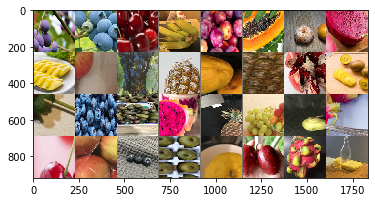

In [0]:
# functions to show an image for debugging and viewing dataset
def unnormalize(x, mean, std):
  x = x * np.array(std).reshape(x.shape[0], 1, 1) + np.array(mean).reshape(x.shape[0], 1, 1)
  return x

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def showimg(tensor, normalization=None):
    # tensor = tensor / 2 + 0.5     # unnormalize, because normalization is (img - 0.5)/0.5 in transforms.Normalize
    npimg = tensor.numpy()
    if normalization:
      npimg = unnormalize(npimg, normalization['mean'], normalization['std'])
    plt.imshow((np.transpose(npimg, (1, 2, 0))* 255).astype(np.uint8))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print("Is CUDA available?",torch.cuda.is_available())
showimg(torchvision.utils.make_grid(images), normalization=SOURCE_NORMALIZATION)

In [0]:
# For Resnet 34
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Training
preprocessing = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

# Validation
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:694: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


# NETWORK



# Model Structure 
* https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py


In [0]:
import torch
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Network(nn.Module):

    def __init__(self, block=BasicBlock, layers=[3, 4, 6, 3], num_classes=18, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, pretrained=False, progress=True):
        super(Network, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

        if pretrained:
          state_dict = load_state_dict_from_url('https://download.pytorch.org/models/resnet34-333f7ec4.pth',
                                              progress=progress)
          self.load_state_dict(state_dict)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward



In [0]:
import torch.optim as optim
net = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0001) # regularisation tecnique to reduce overfitting 
#scheduler = ReduceLROnPlateau(optimizer, 'min')

In [0]:
import pdb; 

training_losses = []
epochs = []
batches = []
validation_losses = []
validation_accuracies = []
training_losses = []
training_accuracies = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    running_loss_training = 0.0
    #pdb.set_trace()
    
    for i, data in enumerate(train_loader, 0):
      
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # val_loss = validate()
        # Note that step should be called after validate()
        # print statistics
        running_loss_training += loss.item()
        
        # find the training accuracy 
        _, predicted_training = torch.max(outputs.data, 1)
        total_training += labels.size(0)
        correct_training += (predicted_training == labels).sum().item()
        #pdb.set_trace()
        
        if i % nMiniBatches == nMiniBatches-1:    # print every n mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss_training / nMiniBatches))
            
            # find the training loss
            training_losses.append(running_loss_training/nMiniBatches)
            epochs.append(epoch+1)
            batches.append(i+1 + epoch*len(train_set)/BATCH_SIZE)
            
            # find the training accuracy
            training_accuracy = 100 * float(correct_training) / total_training   
            training_accuracies.append(training_accuracy) 
            
            running_loss_training = 0.0
            total_training = 0 
            correct_training = 0

            running_validation_loss = 0
            correct_validation = 0
            total = 0  
                
            # calulate the training loss and validation periodically 
            for i, validation_data in enumerate(validation_loader, 0):
              with torch.no_grad():
                # get the inputs
                inputs, validation_labels = validation_data
                inputs, validation_labels = inputs.to(device),validation_labels.to(device)
                
                # calculate validation loss 
                validation_outputs = net(inputs)
                validation_loss = criterion(validation_outputs, validation_labels)
                #scheduler.step(validation_loss)
                running_validation_loss += validation_loss.item()
                
                # calcualte validation accuracy
                _, predicted = torch.max(validation_outputs.data, 1)
                total += validation_labels.size(0)
                correct_validation += (predicted == validation_labels).sum().item()
 
            validation_losses.append(running_validation_loss/len(validation_loader))
            validation_accuracy = 100 * float(correct_validation) / total   
            validation_accuracies.append(validation_accuracy)
            
print('Finished Training')

[1,    20] loss: 3.081
[1,    40] loss: 2.988
[1,    60] loss: 2.960
[1,    80] loss: 2.557
[2,    20] loss: 2.996
[2,    40] loss: 2.400
[2,    60] loss: 2.315
[2,    80] loss: 2.329
[3,    20] loss: 2.528
[3,    40] loss: 2.207
[3,    60] loss: 2.224
[3,    80] loss: 2.145
[4,    20] loss: 2.487
[4,    40] loss: 2.240
[4,    60] loss: 2.097
[4,    80] loss: 2.155
[5,    20] loss: 2.271
[5,    40] loss: 2.147
[5,    60] loss: 2.046
[5,    80] loss: 2.040
[6,    20] loss: 2.161
[6,    40] loss: 2.196
[6,    60] loss: 2.047
[6,    80] loss: 1.892
[7,    20] loss: 2.107
[7,    40] loss: 1.998
[7,    60] loss: 1.873
[7,    80] loss: 1.998
[8,    20] loss: 2.657
[8,    40] loss: 2.260
[8,    60] loss: 2.076
[8,    80] loss: 2.025
[9,    20] loss: 1.999
[9,    40] loss: 2.028
[9,    60] loss: 1.964
[9,    80] loss: 1.970
[10,    20] loss: 2.058
[10,    40] loss: 1.869
[10,    60] loss: 1.962
[10,    80] loss: 1.874
[11,    20] loss: 2.003
[11,    40] loss: 1.841
[11,    60] loss: 1.811
[11,

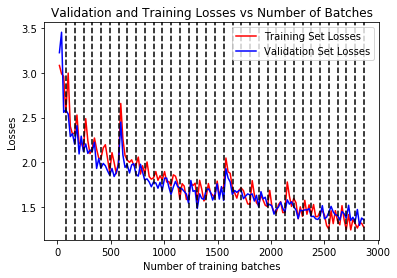

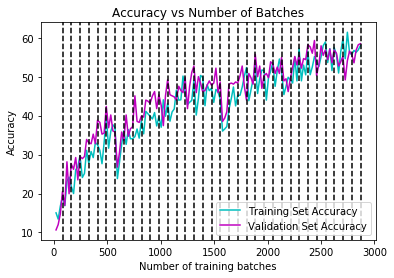

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show the loss
plt.plot(batches, training_losses, 'r', label='Training Set Losses')
plt.plot(batches, validation_losses, 'b', label='Validation Set Losses')
for i in range(EPOCHS):
    plt.axvline(x=(i+1)*len(train_set)/BATCH_SIZE,  color='black', linestyle='dashed')
plt.title('Validation and Training Losses vs Number of Batches')
plt.ylabel('Losses')
plt.xlabel('Number of training batches')

plt.legend(loc='upper right')
plt.show()

# functions to show the accuracy 
plt.plot(batches, training_accuracies, 'c', label='Training Set Accuracy')
plt.plot(batches, validation_accuracies, 'm', label='Validation Set Accuracy')
for i in range(EPOCHS):
    plt.axvline(x=(i+1)*len(train_set)/BATCH_SIZE,  color='black', linestyle='dashed')
plt.title('Accuracy vs Number of Batches')
plt.ylabel('Accuracy')
plt.xlabel('Number of training batches')

plt.legend(loc='lower right')
plt.show()